## Safe city EDA and vectorization project

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
%matplotlib inline
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import math
from tqdm import tqdm
import pickle

### Data loading

In [4]:
3.train = pd.read_csv(r"D:\Main thesis\safecity-master\safe_city_datasets\multilabel_classification\multi_train.csv\train.csv")
test = pd.read_csv(r"D:\Main thesis\safecity-master\safe_city_datasets\multilabel_classification\multi_test.csv\test.csv")
validation = pd.read_csv(r"D:\Main thesis\safecity-master\safe_city_datasets\multilabel_classification\multi_dev.csv\dev.csv")

In [5]:
print(f"The shape of the train data {train.shape}")
print(f"The shape of the validation data {validation.shape}")
print(f"The shape of the test data {test.shape}")

The shape of the train data (7201, 4)
The shape of the validation data (990, 4)
The shape of the test data (1701, 4)


Columns in the data frame

In [6]:
train.columns

Index(['Description', 'Commenting', 'Ogling/Facial Expressions/Staring',
       'Touching /Groping'],
      dtype='object')

Since the column names are lengthier, will keep the short column names

In [7]:
def rename_columns(df):
    column_mapping = {'Ogling/Facial Expressions/Staring':'Ogling', 'Touching /Groping':'Groping'}
    df.rename(columns = column_mapping, inplace = True)
    return df

In [8]:
train = rename_columns(train)
validation = rename_columns(validation)
test = rename_columns(test)

print(f"After renaming train column names: {train.columns}")
print(f"After renaming test column names: {test.columns}")
print(f"After renaming valid column names: {validation.columns}")

After renaming train column names: Index(['Description', 'Commenting', 'Ogling', 'Groping'], dtype='object')
After renaming test column names: Index(['Description', 'Commenting', 'Ogling', 'Groping'], dtype='object')
After renaming valid column names: Index(['Description', 'Commenting', 'Ogling', 'Groping'], dtype='object')


### Observation of data in each categories for training, testing and validation

In [9]:
def find_individual_counts_of_output_labels(df, n):
    count_values = [df.shape[0]]
    for col in df.columns:
        if col != 'Description':
            count_value = df[df[col]==n].shape[0]
            count_values.append(count_value)
    return count_values

In [10]:
# initializing the data
def plot_histogram(df, n):
    x = df.columns
    y = find_individual_counts_of_output_labels(df, n)
    plt.bar(x, y)
    plt.title(f"Distribution of class labels of value {n}")
    plt.ylabel('Number of data points')
    plt.xlabel('Categories')
    plt.show()

Plotting Train output histogram for the different labels

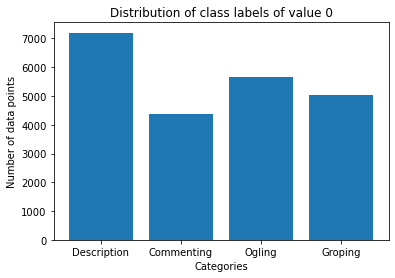

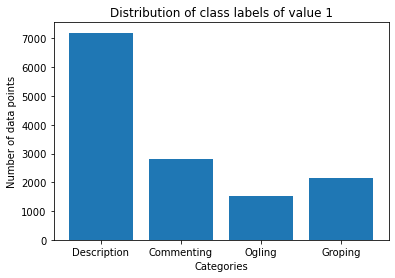

In [11]:
#plot for train
plot_histogram(train, 0)
plot_histogram(train, 1)

In the above plot Commenting has higher positive rate than other labels and Ogling has higher negative rate than other labels



Plotting Test output histogram for the different labels

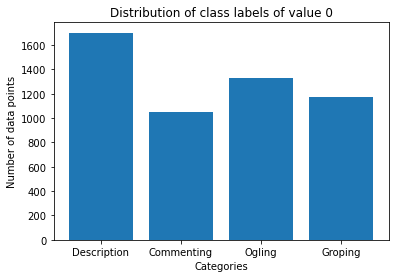

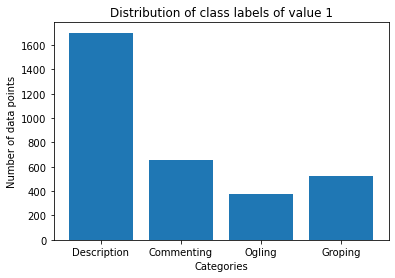

In [12]:
#plot for test
plot_histogram(test, 0)
plot_histogram(test, 1)

Plotting Valid output histogram for the different labels

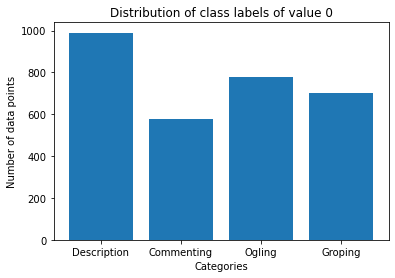

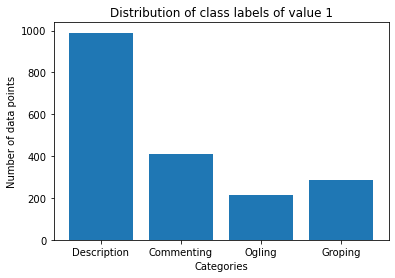

In [13]:
#plot for validation
plot_histogram(validation, 0)
plot_histogram(validation, 1)

All of the above plot have similar sort of distribution in all train, test and validation data for both the Positive and Negative labels.

Positive: Commenting has higher positive rate so the order is  Commenting > Groping > Ogling

Negative : Ogling has higher negative rate so the order is Ogling > Groping> Commenting

In [14]:
#concatenate
data = pd.concat([train, validation], axis=0, ignore_index=True)
print("Data head: ",data.head())

Data head:                                           Description  Commenting  Ogling  \
0  Was walking along crowded street, holding mums...           0       0   
1  This incident took place in the evening.I was ...           0       1   
2  I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...           1       0   
3                 Incident happened inside the train           0       0   
4  I witnessed an incident when a chain was bruta...           0       0   

   Groping  
0        1  
1        0  
2        0  
3        0  
4        0  


### Get features

In [15]:
features = data.columns
print("Features: ", features)

Features:  Index(['Description', 'Commenting', 'Ogling', 'Groping'], dtype='object')


There are four features in the given data.

One feature belongs to input that is "Description". This column has to 
Other three features belongs to three columns are 'Commenting', 'Ogling' and 'Groping'

### Drop Duplicate

In [16]:
duplicates_values = data.duplicated(subset='Description', keep=False)
desc = data[duplicates_values]['Description']
desc

8                                          Sexual Invites
9                                    poor street lighting
24                                             harassment
28                              teachers  beating  pupils
30      I am shocked why there have been no incident r...
                              ...                        
8171                   north east girl sexually assaulted
8173                                           harassment
8180    there was a rape that was seen where at 12 am ...
8181    No proper lighting in the night. No security n...
8190     Tried to touch my breast with his elbow and hand
Name: Description, Length: 864, dtype: object

Finding Unique description from the cells and try to find the invalid output

In [17]:
print(f"The total number of unique values {desc.unique().size} among the number of duplicates {desc.shape[0]}")

The total number of unique values 206 among the number of duplicates 864


Will find out unique duplicate values

In [18]:
data.loc[desc[desc=='harassment'].index]

,Description,Commenting,Ogling,Groping
24,harassment,1,0,0
40,harassment,0,1,0
139,harassment,0,0,0
288,harassment,0,1,1
630,harassment,0,0,1
...,...,...,...,...
7973,harassment,0,1,1
7981,harassment,0,0,1
8109,harassment,1,1,1
8131,harassment,1,0,1


From the above result for the same description, we do observe that there many entries available for the same values and the resultant output differ a lot within the entry

In [19]:
unique = desc.unique()
duplicates_count = {}
for value in unique.tolist():
    duplicates_count[value] = data.loc[desc[desc==value].index].shape[0]

We got the counts of the each of the description with duplicates.
Let`s plot and see the same in histogram to understand the data redunancy and try to combine their results in the output

In [20]:
desc_keys = duplicates_count.keys()
desc_keys = map(lambda x: x.split(" ")[0], desc_keys)

sorted_dict = dict(sorted(duplicates_count.items(), key = lambda item: item[1]))

In [21]:
sorted_duplicate_desc_list = list(sorted_dict)

### Least Formed Duplicates

In [22]:
least_formed_duplicates = sorted_duplicate_desc_list[:25]

Plot histogram of duplicates

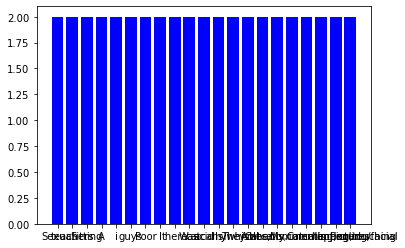

In [23]:
least_formed_values = {key.split(" ")[0]: duplicates_count[key] for key in least_formed_duplicates}

plt.bar(list(least_formed_values.keys()), least_formed_values.values(), color='b')
plt.show()

Above plot describes 25 least number of duplicates

In [24]:
print(f"least formed duplicates: {least_formed_values}")

least formed duplicates: {'Sexual': 2, 'teachers': 2, 'Sitting': 2, 'A': 2, 'i': 2, 'guys': 2, 'Poor': 2, 'I': 2, 'there': 2, 'Was': 2, 'acid': 2, 'my': 2, 'They': 2, 'An': 2, 'when': 2, 'My': 2, 'catcalls/whistles,commenting,ogling/facial': 2, 'Catcalls': 2, 'Catcalls,commenting,touching': 2, 'happened': 2, 'Pictures': 2}


#### Highly formed duplicates 

In [25]:
highly_formed_duplicates = sorted_duplicate_desc_list[-10:]
print(f"Highly formed duplicates: {highly_formed_duplicates}")

Highly formed duplicates: ['Commenting', 'catcalls', 'This survey is carried out by safecity (Red dot foundation) along with its safety audit at street markets in Mumbai.', 'I was commented at', 'commenting', 'chain snatching', 'This survey is carried out by safecity (Red Dot Foundation) along with its safecity audit at street market in Mumbai.', 'it was really bad.', 'misbehaved', 'harassment']


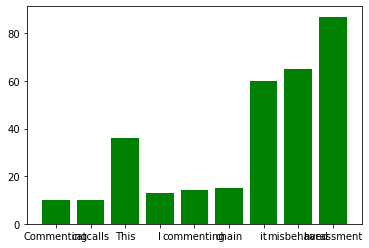

In [26]:
highly_formed_values = {key.split(" ")[0]: duplicates_count[key] for key in highly_formed_duplicates}

plt.bar(list(highly_formed_values.keys()), highly_formed_values.values(), color='g')
plt.show()

1. Above plot describes top 10 duplicates. The most top duplicates is harassment and it may fall into all types of sexual harrassment. 


2. Others are Commenting', 'catcalls', 'This survey is carried out by safecity (Red dot foundation) along with its safety audit at street markets in Mumbai.', 'I was commented at', 'commenting', 'chain snatching', 'This survey is carried out by safecity (Red Dot Foundation) along with its safecity audit at street market in Mumbai.', 'it was really bad.', 'misbehaved. 


3. I think the city names is not a part of an harrassment and it does not gives output label. But it may help to predict the most harrassment caused in the particular city. This may not work here because we are categorizing the type of sexual harrassment not based on city. So, we can include the city names in the stopwords.

In [27]:
print(duplicates_values.sum())

864


In [28]:
data[duplicates_values]

,Description,Commenting,Ogling,Groping
8,Sexual Invites,0,0,0
9,poor street lighting,0,0,1
24,harassment,1,0,0
28,teachers beating pupils,0,0,0
30,I am shocked why there have been no incident r...,1,0,1
...,...,...,...,...
8171,north east girl sexually assaulted,0,0,1
8173,harassment,1,0,0
8180,there was a rape that was seen where at 12 am ...,0,0,0
8181,No proper lighting in the night. No security n...,0,0,0


In [29]:
data[duplicates_values][-10:]

,Description,Commenting,Ogling,Groping
8132,As a participant crisscrossed the citys roads ...,0,0,0
8137,Commenting,1,0,0
8139,it was really bad.,1,0,0
8150,misbehaved,1,1,1
8168,stalking,0,0,0
8171,north east girl sexually assaulted,0,0,1
8173,harassment,1,0,0
8180,there was a rape that was seen where at 12 am ...,0,0,0
8181,No proper lighting in the night. No security n...,0,0,0
8190,Tried to touch my breast with his elbow and hand,0,0,1


In [30]:
data.drop_duplicates(subset="Description", keep='first', inplace=True, ignore_index=False)

In [31]:
print("Data after drop_duplication", data.shape)

Data after drop_duplication (7533, 4)


In [32]:
data.describe()

,Commenting,Ogling,Groping
count,7533.000000,7533.000000,7533.000000
mean,0.382716,0.204168,0.297889
std,0.486082,0.403119,0.457361
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


In [33]:
data.sum(skipna=True)

Description    Was walking along crowded street, holding mums...
Commenting                                                  2883
Ogling                                                      1538
Groping                                                     2244
dtype: object

#### Checking null values 


In [34]:
train.isnull().sum()

Description    0
Commenting     0
Ogling         0
Groping        0
dtype: int64

In [35]:
test.isnull().sum()

Description    0
Commenting     0
Ogling         0
Groping        0
dtype: int64

In [36]:
validation.isnull().sum()

Description    0
Commenting     0
Ogling         0
Groping        0
dtype: int64

# Word cloud for each and every category

In [37]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud(data, column):  # ref: https://www.geeksforgeeks.org/generating-word-cloud-python/
    comment_words = ''
    stopwords = set(STOPWORDS)
    # iterate through the csv file
    for val in data[column]:
        # typecaste each val to string
        val = str(val)
        # split the value
        tokens = val.split()
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
            comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 500, height = 500,background_color ='black',stopwords = stopwords, min_font_size = 10).generate(comment_words)
    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

# word cloud for "Commenting"

In [36]:
commenting = train[(train['Commenting']==1)]

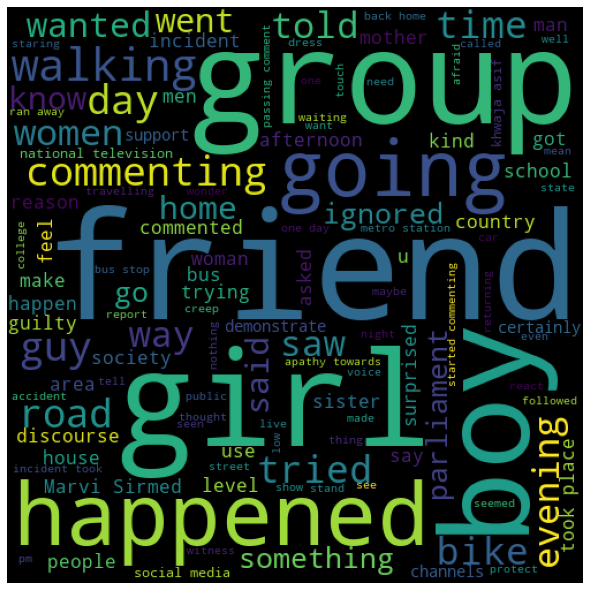

In [37]:
word_cloud(commenting, 'Description')

# word cloud for "Ogling"

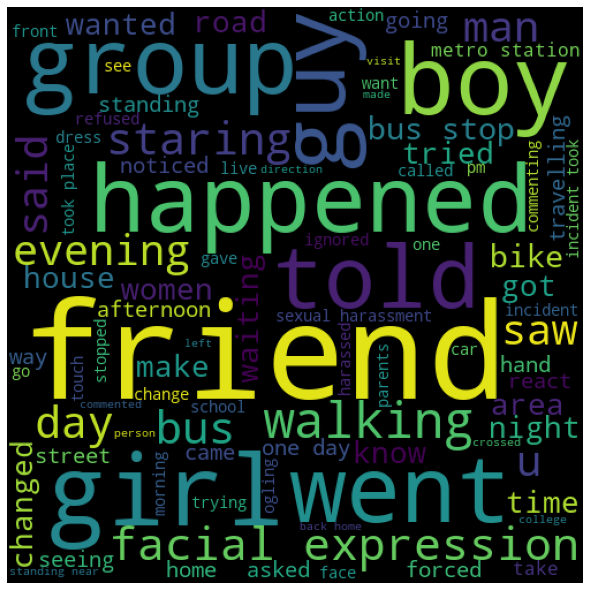

In [38]:
ogling = train[(train['Ogling']==1)]
word_cloud(ogling, 'Description')

# word cloud for "Groping"

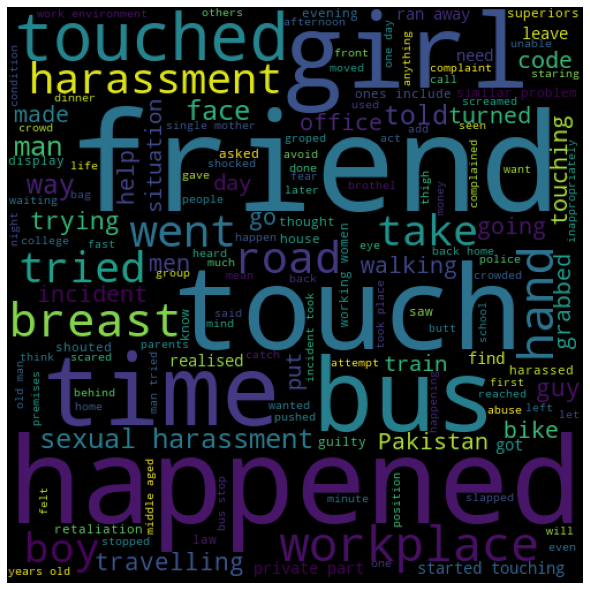

In [39]:
Groping = train[(train['Groping']==1)]
word_cloud(Groping, 'Description')

### Feature Engineering

In [38]:
description = data.Description
description.head()

0    Was walking along crowded street, holding mums...
1    This incident took place in the evening.I was ...
2    I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...
3                   Incident happened inside the train
4    I witnessed an incident when a chain was bruta...
Name: Description, dtype: object

In [39]:
import nltk
from nltk.corpus import stopwords
import enchant

In [40]:
def feature_before_preprocessing(data, text_column): 
    '''
    data : dataframe 
    text_column : column name 
    '''
    
    punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    stop_words = set(stopwords.words('english'))
    data['description_len'] = data[text_column].astype(str).apply(len)  # length of the text
    data['word_count'] = data[text_column].apply(lambda x: len(str(x).split()))  # count of words 
    data['word_density'] = data['description_len'] / (data['word_count']+1)  # density of description

    data['punctuation_count'] = data[text_column].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) # count of punctuation 
    data['title_word_count'] = data[text_column].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # count of title 
    data['upper_case_word_count'] = data[text_column].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))  # upper case word count
    data['stopword_count'] = data[text_column].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))  # count of stopwords
    return data
  
train = feature_before_preprocessing(data, "Description")   # get the features
test = feature_before_preprocessing(test, "Description")
test.head()

,Description,Commenting,Ogling,Groping,description_len,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
0,"During morning, a woman was walking by and thi...",1,1,0,151,30,4.870968,4,2,0,13
1,A man tried to brush his penis off of a woman'...,0,0,1,68,15,4.250000,2,1,1,8
2,This happened to a fellow passenger of mine tr...,0,1,0,151,25,5.807692,2,2,0,14
3,ogling,0,1,0,6,1,3.000000,0,0,0,0
4,When I was returning my home after finishing m...,0,0,1,185,40,4.512195,2,3,2,25


In [41]:
import re
from nltk.stem import WordNetLemmatizer  # lemmatizer
from nltk.stem import PorterStemmer #Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):

    text = ' '.join(e for e in text.split() if e.lower() not in stopwords.words('english') and len(e)>2) 
    # convert to lower and remove stopwords discard words whose len < 2
    text = re.sub(r"won\'t", "", text) # decontracting the words
    text = re.sub(r"can\'t", "", text)
    text = re.sub(r"n\'t", "", text)
    text = re.sub(r"\'re", "", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'d", "", text)
    text = re.sub(r"\'ll", "", text)
    text = re.sub(r"\'t", "", text)
    text = re.sub(r"\'ve", "", text)
    text = re.sub(r"\'m", "", text)
    text = re.sub(r'\W', ' ', str(text))  # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # remove all single characters 
    text = re.sub(r"[0-9]", " ", text)  # replace number with space
    text = re.sub(r"[^A-Za-z_]", " ", text)  # replace all the words except "A-Za-z_" with space
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower().strip()   # strip

    # Lemmatization
    tokens = text.split()
    
    tokens_res = []
    
    for word in tokens:
        word = lemmatizer.lemmatize(word)
        word = stemmer.stem(word)
        if word not in stop_words and len(word) > 2:
            tokens_res.append(word)
    
    new_text = ' '.join(tokens_res)
    
    return new_text

#         if word not in correct_words:
#             temp = [(edit_distance(word, w),w) for w in correct_words if w[0]==word[0]]
#             word = sorted(temp, key = lambda val:val[0])[0][1]
# preprocessing the description column
train['Description'] = train['Description'].map(lambda a: preprocess(a))   
test['Description']= test['Description'].map(lambda a: preprocess(a))

In [42]:
train_text = list(train.Description.values)
test_text = list(test.Description.values)

#### Vectorization of the pre-processed data

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

### Bag of Words 

In [44]:
def bagOfWordsWithTrainTestData(train_data, test_data, max_features=500, min_df=5):
    count_vect = CountVectorizer(stop_words='english',max_features=max_features, min_df=min_df)
    
    train_data_vectorized = count_vect.fit_transform(train_data)
    print("some feature names after transforming the TRAIN data", count_vect.get_feature_names()[:10])
    
    test_data_vectorized = count_vect.transform(test_data)
    print("some feature names after transforming the TEST data", count_vect.get_feature_names()[:10])
    
    print("the type of count vectorizer ",type(train_data_vectorized))
    print("the shape of out text BOW vectorizer ",train_data_vectorized.get_shape())
    
    print("the type of count vectorizer ",type(test_data_vectorized))
    print("the shape of out text BOW vectorizer ",test_data_vectorized.get_shape())
    
    return count_vect, train_data_vectorized, test_data_vectorized

In [45]:
bow_count_vect, bow_train_data_vectorized, bow_test_data_vectorized =  bagOfWordsWithTrainTestData(train_text, test_text, max_features=1000, min_df=15)

some feature names after transforming the TRAIN data ['abl', 'abus', 'accept', 'act', 'action', 'activ', 'actual', 'address', 'advanc', 'advantag']
some feature names after transforming the TEST data ['abl', 'abus', 'accept', 'act', 'action', 'activ', 'actual', 'address', 'advanc', 'advantag']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7533, 656)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1701, 656)


C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
def bagOfWordsWithTrainTestData2(train_data, max_features=500, min_df=5):
    count_vect = CountVectorizer(stop_words='english',max_features=max_features, min_df=min_df)
    
    train_data_vectorized = count_vect.fit_transform(train_data)
    
    return count_vect

In [47]:
bow_count_vect = bagOfWordsWithTrainTestData2(train_text,max_features=1000, min_df=15)

# Save bag of words in pickle format

In [48]:
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/bow_count_vect.pkl", "wb") as pickle_file:
    pickle.dump(bow_count_vect, pickle_file) 
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/bow_count_vect.pkl", "rb") as pickel_file:
    loaded_model = pickle.load(pickel_file)  

In [49]:
bow_count_vect.get_feature_names_out()

array(['abl', 'abus', 'accept', 'act', 'action', 'activ', 'actual',
       'address', 'advanc', 'advantag', 'afraid', 'afternoon', 'age',
       'ago', 'ahead', 'alcohol', 'alon', 'alreadi', 'alway', 'amp',
       'angri', 'annoy', 'anoth', 'anyon', 'anyth', 'appear', 'approach',
       'area', 'arm', 'arriv', 'ask', 'assault', 'attack', 'attempt',
       'attend', 'attent', 'aunt', 'auto', 'avoid', 'away', 'awkward',
       'bad', 'badli', 'bag', 'bandra', 'beat', 'beaten', 'beauti',
       'becam', 'becom', 'began', 'behav', 'behaviour', 'believ', 'besid',
       'best', 'big', 'bike', 'biker', 'bit', 'block', 'board', 'bodi',
       'boy', 'boyfriend', 'breast', 'bridg', 'broad', 'brother', 'brush',
       'build', 'bunch', 'bush', 'busi', 'butt', 'buttock', 'buy', 'cab',
       'came', 'campu', 'car', 'care', 'carri', 'case', 'cat', 'catcal',
       'catch', 'caught', 'caus', 'centr', 'certain', 'chain', 'chang',
       'chase', 'cheap', 'check', 'chest', 'child', 'chowk', 'church'

## TF IDF Vectorizer

In [50]:
def tfIdfWithTrainTestData(train_data, test_data, max_features=500, min_df=10):
    tf_idf_vect = TfidfVectorizer(min_df=min_df, max_features=max_features) #in scikit-learn
    
    train_data_vectorized = tf_idf_vect.fit_transform(train_data)
    test_data_vectorized = tf_idf_vect.transform(test_data)
    
    print("the type of count vectorizer ",type(train_data_vectorized))
    print("the shape of out text TF_IDF vectorizer ",train_data_vectorized.get_shape())
    
    print("the type of count vectorizer ",type(test_data_vectorized))
    print("the shape of out text TF_IDF vectorizer ",test_data_vectorized.get_shape())
    
    return tf_idf_vect, train_data_vectorized, test_data_vectorized

In [51]:
tf_idf_vect, tf_idf_train_data_vectorized, tf_idf_test_data_vectorized = tfIdfWithTrainTestData(train_text, test_text, 1000, 15)

<IPython.core.display.Javascript object>

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TF_IDF vectorizer  (7533, 716)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TF_IDF vectorizer  (1701, 716)


In [52]:
def tfIdfWithTrainTestData2(train_data, max_features=500, min_df=10):
    tf_idf_vect = TfidfVectorizer(min_df=min_df, max_features=max_features) #in scikit-learn
    train_data_vectorized = tf_idf_vect.fit_transform(train_data)
    return tf_idf_vect

In [53]:
tf_idf_vect =tfIdfWithTrainTestData2(train_text,1000, 15)

<IPython.core.display.Javascript object>

# save tfidf words in pickle format

In [54]:
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/tfidf.pkl", "wb") as pickle_file:
    pickle.dump(tf_idf_vect, pickle_file)   

In [55]:
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/tfidf.pkl", "rb") as pickel_file:
    loaded_model = pickle.load(pickel_file)    

In [56]:
vect_dict = {
    'bow_count_vect': bow_count_vect,
    'tfidf_vect': tf_idf_vect
}

with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/dict.pkl", "wb") as pickle_file:
    pickle.dump(vect_dict, pickle_file)     

In [57]:
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/dict.pkl", "rb") as pickel_file:
    loaded_model = pickle.load(pickel_file)

In [58]:
loaded_model

{'bow_count_vect': CountVectorizer(max_features=1000, min_df=15, stop_words='english'),
 'tfidf_vect': TfidfVectorizer(max_features=1000, min_df=15)}

## Word to Vector 

In [59]:
def convertWordsToVectors(data, model, w2v_words, vector_size=50):
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(data): # for each review/sentence
        sent_vec = np.zeros(vector_size) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [60]:
def convertW2v(train_data, test_data, vector_size=50):
    
    list_of_sentance=[]
    for sentance in train_data:
        list_of_sentance.append(sentance.split())
    
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=vector_size, workers=4)
    w2v_model.save("word2vec.model")
    u = w2v_model.wv
    v = w2v_model.wv.key_to_index
    w2v_words = list(w2v_model.wv.key_to_index)
    
    w2v_train = convertWordsToVectors(list_of_sentance, w2v_model, w2v_words, vector_size)
    
    list_of_sentance=[]
    for sentance in test_data:
        list_of_sentance.append(sentance.split())
    
    w2v_test = convertWordsToVectors(list_of_sentance,w2v_model,w2v_words, vector_size)
    
    return w2v_train,w2v_test

In [61]:
train_w2v_data, test_w2v_data = convertW2v(train_text, test_text, 100)

100%|███████████████████████████████████████████████████████████████████████████| 1701/1701 [00:00<00:00, 10208.33it/s]


In [62]:
len(train_w2v_data), train_w2v_data[0].shape

(7533, (100,))

In [63]:
len(test_w2v_data), test_w2v_data[0].shape

(1701, (100,))

### TF-IDF Word2Vec 

In [64]:
def convertSentVectors(list_of_sentance,dictionary, w2v_model, w2v_words, tfidf_feat):
        # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    return tfidf_sent_vectors

def convertW2v_Tf_Idf(train_data,test_data):
    
    list_of_sentance=[]
    for sentance in train_data:
        list_of_sentance.append(sentance.split())
    
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
    w2v_words = list(w2v_model.wv.key_to_index)
    
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(train_data)
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    
    train_sent_vectors = convertSentVectors(list_of_sentance,dictionary, w2v_model,w2v_words,tfidf_feat)
    
    list_of_sentance=[]
    for sentance in test_data:
        list_of_sentance.append(sentance.split())
    
    test_sent_vectors = convertSentVectors(list_of_sentance,dictionary, w2v_model,w2v_words,tfidf_feat)
    
    w2v_model.save("w2v_model_tfidf.model")
        
    return train_sent_vectors,test_sent_vectors

In [65]:
train_w2v_tfidf_data, test_w2v_tfidf_data = convertW2v_Tf_Idf(train_text, test_text)

<IPython.core.display.Javascript object>

C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|████████████████████████████████████████████████████████████████████████████| 1701/1701 [00:00<00:00, 1815.36it/s]


In [66]:
train_w2v_tfidf_data

[array([ 0.0892067 ,  0.02267237, -0.12594322,  0.03576808,  0.08629253,
        -0.45538423,  0.34920623,  0.92259106, -0.70674987, -0.27704829,
         0.06287425, -0.48187386,  0.05203064,  0.14691601, -0.27061322,
         0.03848327,  0.37745571,  0.11680526, -0.59411508, -0.20568758,
         0.14995924,  0.39292178,  0.5887427 , -0.1160122 ,  0.54860516,
         0.13950354, -0.41297824, -0.22798708, -0.49119622,  0.22054882,
         0.27983776, -0.01483512, -0.27001734, -0.11566731, -0.57580173,
         0.59377069,  0.31187699,  0.1357616 ,  0.17519045, -0.44257159,
         0.36518091, -0.12898413, -0.12003604,  0.10049798,  1.02370505,
         0.16764521, -0.19511094, -0.48265938,  0.40983265,  0.05011856]),
 array([ 0.18614769, -0.05930758,  0.11656326, -0.07997928,  0.22220934,
        -0.62466167,  0.45936774,  1.09232187, -0.78407881, -0.56383286,
        -0.07372765, -0.78558181,  0.24210937,  0.39910336, -0.12554315,
         0.26834041,  0.55732581,  0.07653011, -0

In [67]:
len(train_w2v_tfidf_data), train_w2v_tfidf_data[0].shape[0]

(7533, 50)

In [68]:
len(test_w2v_tfidf_data), test_w2v_tfidf_data[0].shape[0]

(1701, 50)

### KPI metrics 

In [69]:
from sklearn.metrics import multilabel_confusion_matrix
y_true = np.array([[1, 0, 1],[0, 1, 0]])
y_pred = np.array([[1, 0, 0],[0, 1, 1]])
multilabel_confusion_matrix(y_true, y_pred)

array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [0, 1]],

       [[0, 1],
        [1, 0]]], dtype=int64)

In [70]:
def metrics(y_true, y_pred):
    
    actual = y_true.tolist()
    pred = y_pred.tolist()

    FP = 0
    FN = 0
    TP = 0
    TN = 0
    for i in range(len(actual)):
        for m in range(len(actual[0])):
            for j in range(len(pred)):
                for k in range(len(pred[0])):
                    if actual[i][k] == 0 and pred[j][k] == 1:
                        FP += 1
                    elif actual[i][k] == 1 and pred[j][k] == 0:
                        FN += 1
                    elif actual[i][k] == 0 and pred[j][k] == 0:
                        TN += 1
                    else:
                        TP += 1
    return TP, FP, TN, FN   

In [71]:
TP,FP,TN,FN = metrics(y_true, y_pred)
TP,FP,TN,FN

(9, 9, 9, 9)

In [72]:
def custom_precision(TP,FP,TN,FN):
    pre = TP/(FP+TP)
    return pre
precision = custom_precision(TP,FP,TN,FN)
precision

0.5

In [73]:
def custom_recall(TP,FP,TN,FN):
    re = TP/(FN+TP)
    return re
recall = custom_recall(TP,FP,TN,FN)
recall

0.5

# Weighted_Average_F1_score

In [74]:
def f1_score(precision, recall):
    score = 2 *((precision*recall)/(precision+recall))
    return score

In [75]:
micro_average_f1_score = f1_score(precision,recall)
micro_average_f1_score 

0.5

In [76]:
from sklearn.metrics import classification_report

In [77]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1

   micro avg       0.67      0.67      0.67         3
   macro avg       0.67      0.67      0.67         3
weighted avg       0.67      0.67      0.67         3
 samples avg       0.75      0.75      0.67         3



In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [79]:
def confusion_matrix(y_test, y_pred):
    cm_array = multilabel_confusion_matrix(y_test, y_pred, labels=[0,1,2])
    f, axes = plt.subplots(1, 3, figsize=(25, 15))
    axes = axes.ravel()
    for i in range(3):
        disp = ConfusionMatrixDisplay(cm_array[i],display_labels=[0, 1])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(f'class {i}')
        if i<10:
            disp.ax_.set_xlabel('')
        if i%3!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    return plt.show()

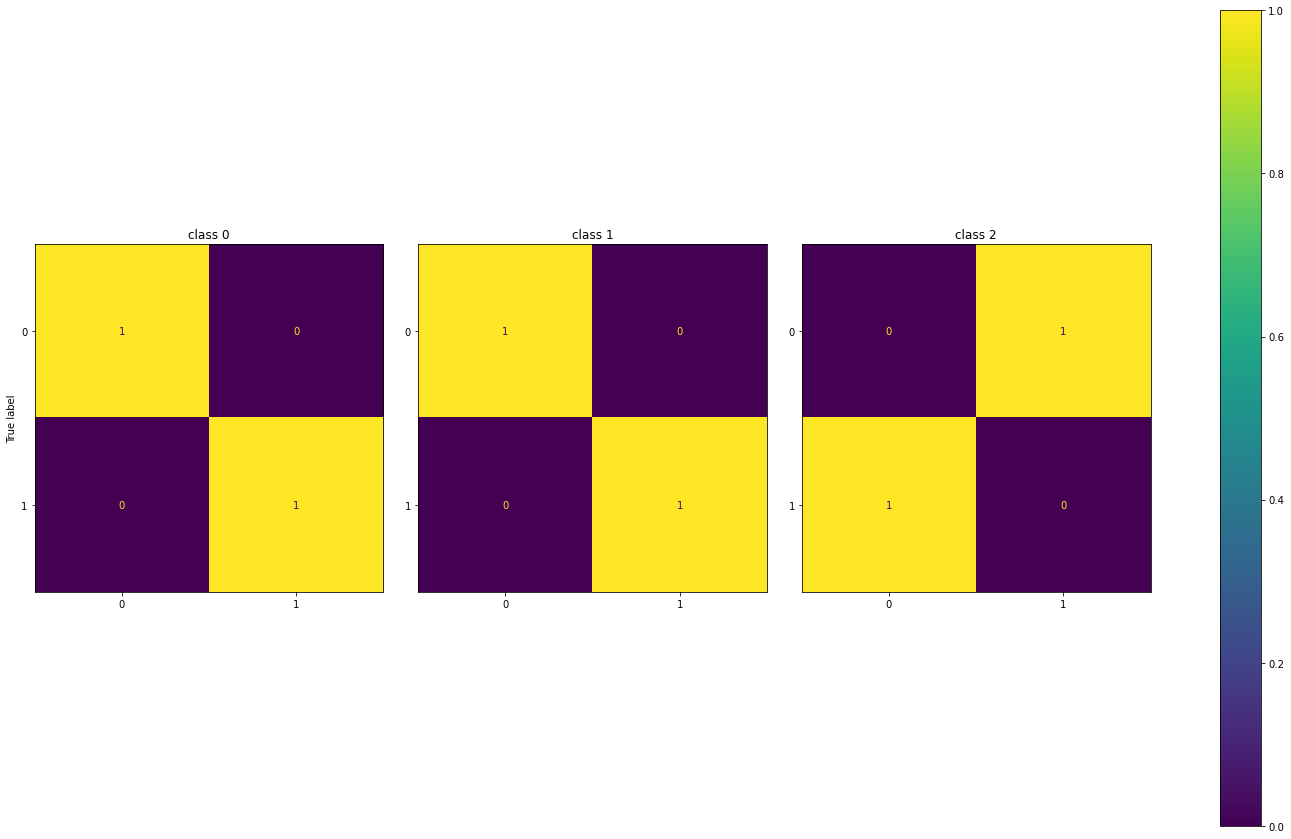

In [80]:
confusion_matrix(y_true, y_pred)

# Balancing the imbalance datasets by using mlsmote

Using tfidf vectorized data and assigning train and test data to use in model

In [81]:
tfidf_X_train, tfidf_y_train = tf_idf_train_data_vectorized, data.iloc[:, 1:4].reset_index(drop=True)
tfidf_X_test, tfidf_y_test = tf_idf_test_data_vectorized, test.iloc[:, 1:4].reset_index(drop=True)

In [82]:
tfidf_y_train_column_names = tfidf_y_train.columns.values
tfidf_y_train_column_names

array(['Commenting', 'Ogling', 'Groping'], dtype=object)

Checking the number of 0's and 1's in the features, how imbalanced it is.

Previously there is a mismatch in input and target variable so here we reset the index for target data to make a unique shape for both input and output data


# BOW Data Splitting

In [83]:
bow_X_train, bow_y_train = bow_train_data_vectorized,  data.iloc[:, 1:4].reset_index(drop=True)
bow_X_test, bow_y_test = bow_test_data_vectorized, test.iloc[:, 1:4].reset_index(drop=True)

# TF_IDF Data Splitting

In [84]:
tfidf_X_train, tfidf_y_train = tf_idf_train_data_vectorized, data.iloc[:, 1:4].reset_index(drop=True)
tfidf_X_test, tfidf_y_test = tf_idf_test_data_vectorized, test.iloc[:, 1:4].reset_index(drop=True)

In [85]:
tfidf_y_train_column_names = tfidf_y_train.columns.values
tfidf_y_train_column_names

array(['Commenting', 'Ogling', 'Groping'], dtype=object)

# Word2vec Data Splitting

In [86]:
w2v_X_train, w2v_y_train = train_w2v_data, data.iloc[:, 1:4].reset_index(drop=True)
w2v_X_test, w2v_y_test = test_w2v_data, test.iloc[:, 1:4].reset_index(drop=True)

# Word2vec_tfidf Data Splitting

In [87]:
w2v_tfidf_X_train, w2v_tfidf_y_train = train_w2v_tfidf_data,  data.iloc[:, 1:4].reset_index(drop=True)
w2v_tfidf_X_test, w2v_tfidf_y_test = test_w2v_tfidf_data, test.iloc[:, 1:4].reset_index(drop=True)

In [88]:
print("BOW Type :",type(bow_X_train) )
print("TFIDF Type :", type(tfidf_X_train))
print("W2V Type :", type(w2v_X_train) )
print("W2v_TFIDF Type :", type(w2v_tfidf_X_train))

BOW Type : <class 'scipy.sparse.csr.csr_matrix'>
TFIDF Type : <class 'scipy.sparse.csr.csr_matrix'>
W2V Type : <class 'list'>
W2v_TFIDF Type : <class 'list'>


In [89]:
data.columns[1:4]

Index(['Commenting', 'Ogling', 'Groping'], dtype='object')

Creating customized function for MLsmote to balance the training data

In [90]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors


"""def convert_array_dataframe(X_train, y_train):
    columns = data.columns[1:4]
    X = pd.DataFrame(np.array(X_train))
    y = pd.DataFrame(y_train, columns)  # columns = y_train_column_names
    return X,y """

def get_tail_label(df):
    
    """
    Give tail label colums of the given target dataframe
    
    args
    
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    print(f"Tail label: {tail_label}")
    return tail_label

def get_index(df):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified

    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label]==1].index)
        index = index.union(sub_index)
    return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

Balancing training data for bag of words

In [91]:
def augment_mlsmote(X_tr, y_tr):   
    
    #columns = y_tr.columns.values
    if type(X_tr) == list:
        X = pd.DataFrame(np.array(X_tr))
    else:
        X = pd.DataFrame(X_tr.toarray())
        
    y = y_tr
    
    X_sub, y_sub = get_minority_instace(X, y)   #Getting minority instance of that datframe
    X_res,y_res = MLSMOTE(X_sub, y_sub, 1000)
    
    augment_X_train = pd.concat([X, X_res], axis = 0).to_numpy()
    augment_y_train = pd.concat([y, y_res], axis = 0).to_numpy()
    
    return augment_X_train, augment_y_train

In [92]:
tf_X_train, tf_y_train  = augment_mlsmote(tfidf_X_train, tfidf_y_train)

Tail label: ['Ogling']


After finding the minority samples we need to concatenate minority datasets with majority datasets to balance the imbalancing data in training sets on both independent and target variables.

In [93]:
tf_X_train.shape, tf_y_train.shape

((10071, 716), (10071, 3))

In [94]:
BOW_X_train, BOW_y_train  = augment_mlsmote(bow_X_train, bow_y_train)

Tail label: ['Ogling']


In [95]:
BOW_X_train.shape, BOW_y_train.shape

((10071, 656), (10071, 3))

In [96]:
w2v_X_train, w2v_y_train  = augment_mlsmote(w2v_X_train, w2v_y_train)

Tail label: ['Ogling']


In [97]:
w2v_X_train.shape, w2v_y_train.shape

((10071, 100), (10071, 3))

In [98]:
w2v_tfidf_X_train, w2v_tfidf_y_train  = augment_mlsmote(w2v_tfidf_X_train, w2v_tfidf_y_train)

Tail label: ['Ogling']


In [99]:
w2v_tfidf_X_train

array([[ 0.0892067 ,  0.02267237, -0.12594322, ..., -0.48265938,
         0.40983265,  0.05011856],
       [ 0.18614769, -0.05930758,  0.11656326, ..., -0.48892972,
         0.27180705,  0.06165163],
       [-0.00940775,  0.045564  , -0.06939541, ..., -0.45912013,
         0.37183552,  0.07345023],
       ...,
       [ 0.16180466,  0.07195272,  0.07196394, ..., -0.47344737,
         0.3215569 ,  0.07262399],
       [ 0.11419757, -0.01050429, -0.02689228, ..., -0.4325765 ,
         0.32607925,  0.02165256],
       [ 0.02246819,  0.1387061 , -0.01533457, ..., -0.4953972 ,
         0.29319083,  0.19547967]])

In [100]:
w2v_tfidf_X_train.shape, w2v_tfidf_y_train.shape

((10071, 50), (10071, 3))

In [101]:
import scipy
from scipy.sparse import csr_matrix

# Problem Transformation Method

# Binary Relevance/OneVsRest

## Naive Bayes


### Featurization tfidf word

In [102]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

In [103]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [104]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scaler(X_train, X_test):
    
    # fit scaler on training data
    norm = MinMaxScaler().fit(X_train)

    # transform training data
    X_train_norm = norm.transform(X_train)

    # transform testing dataabs
    X_test_norm = norm.transform(X_test)
    
    return X_train_norm, X_test_norm

In [105]:
X_train_norm, X_test_norm =  min_max_scaler(tf_X_train, tfidf_X_test.toarray())
#bow_X_train_norm, bow_X_test_norm  = min_max_scaler(bow_X_train, bow_X_test)

# Save model

In [106]:
def min_max_scaler2(X_train):    
    # fit scaler on training data
    norm = MinMaxScaler().fit(X_train)
    # transform training data
    X_train_norm = norm.transform(X_train)    
    return norm

In [107]:
min_max_scaling = min_max_scaler2(tf_X_train)
#write

with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/min_max_scaling.pkl", "wb") as pickle_file:
    pickle.dump(min_max_scaling, pickle_file)     

In [108]:
#open
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/min_max_scaling.pkl", "rb") as pickel_file:
    min_max_scale = pickle.load(pickel_file)   

# Using TF_IDF in Multinomial

In [111]:
def build_binary_relevance(X, Y, X_te):
    parameters = [
    {   
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0, 0.0001, 0.0004, 0.01, 0.1, 0.2, 0.3, 0.5]
    }]

    clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
    clf.fit(X, Y)
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Score: {clf.best_score_}")
    y_pred = clf.predict(X_te)
    return clf, y_pred

In [112]:
BR_clf, BR_pred = build_binary_relevance(X_train_norm, tf_y_train, X_test_norm)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Best parameters: {'classifier': MultinomialNB(alpha=0), 'classifier__alpha': 0}
Best Score: 0.41514633842071574


In [109]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from scipy import sparse
from datetime import datetime
from sklearn.metrics import accuracy_score

In [110]:
def exact_match_ratio(y_true, y_pred):
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

In [111]:
y_train = train[['Commenting', 'Ogling', 'Groping']].values
y_test = test[['Commenting', 'Ogling', 'Groping']].values

In [112]:
def calculate_metrics(predictions):
    
    y_test = test[['Commenting', 'Ogling', 'Groping']].values
    
    print("Hamming Loss: ", hamming_loss(y_test, predictions))
    print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
    print("Recall: ", recall_score(y_true=y_test, y_pred=predictions, average='micro'))
    print("Precision: ", precision_score(y_true=y_test, y_pred=predictions, average='micro'))
    print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))
    print("Accuracy: ", accuracy_score(y_true=y_test, y_pred=predictions))
    print(" ")
    print("*****************************************************************************")
    print("")
    print("metrics.classification_report: ")
    print(classification_report(y_test, predictions)) 

In [117]:
calculate_metrics(BR_pred)

Hamming Loss:  0.28336272780717225
Exact Match Ratio:  0.3856554967666079
Recall:  0.3416988416988417
Precision:  0.5566037735849056
Fl score:  0.423444976076555
Accuracy:  0.3856554967666079
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       654
           1       0.34      0.23      0.27       375
           2       0.75      0.18      0.29       525

   micro avg       0.56      0.34      0.42      1554
   macro avg       0.57      0.32      0.38      1554
weighted avg       0.59      0.34      0.40      1554
 samples avg       0.28      0.24      0.25      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

In [119]:
def confusion_matrix(y_test, y_pred):
    cm_array = multilabel_confusion_matrix(y_test, y_pred, labels=[0,1,2])
    f, axes = plt.subplots(1, 3, figsize=(25, 15))
    axes = axes.ravel()
    for i in range(3):
        #cm = confusion_matrix(y_test[:,1], y_pred.toarray()[:,i])
        #cm = list(cm)
        disp = ConfusionMatrixDisplay(cm_array[i],display_labels=[0, 1])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(f'class {i}')
        if i<10:
            disp.ax_.set_xlabel('')
        if i%3!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    return plt.show()

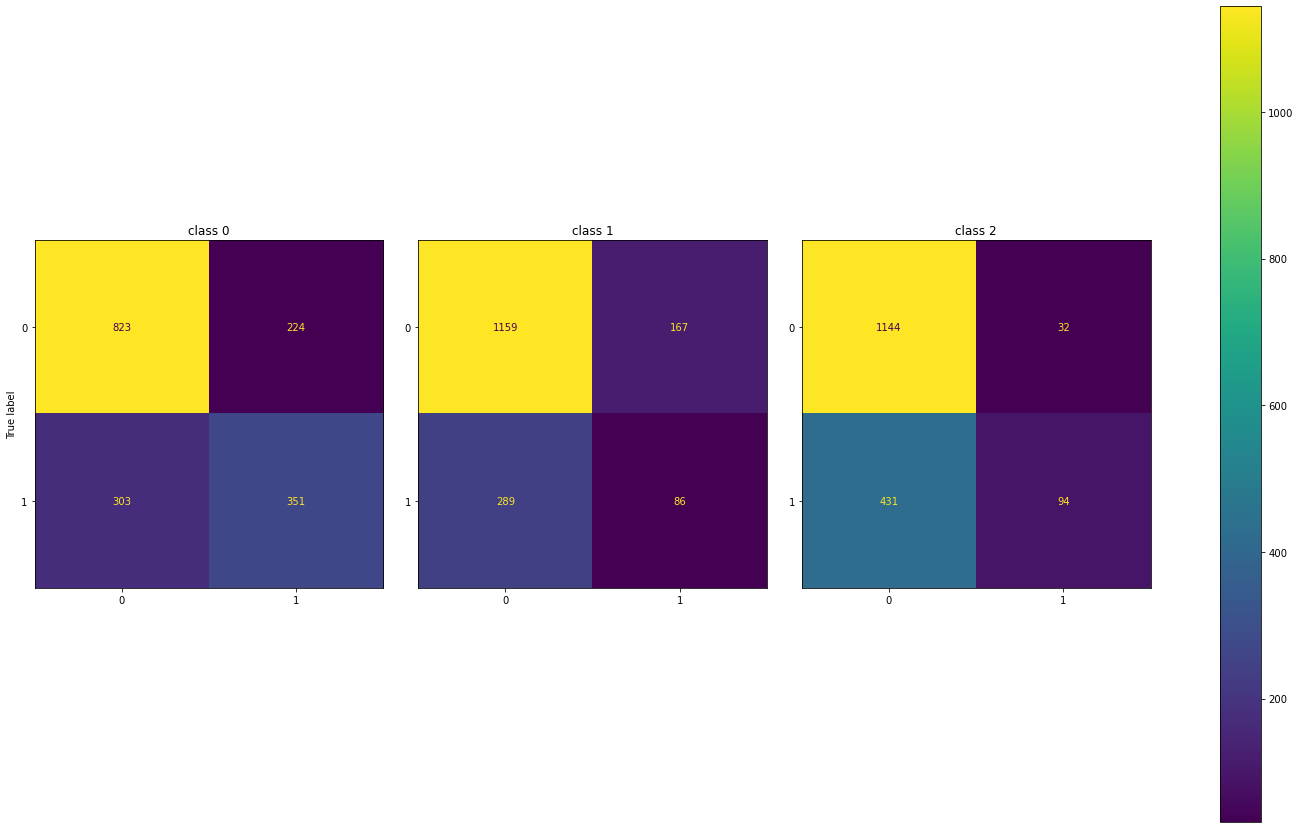

In [120]:
confusion_matrix(y_test, BR_pred)

In [121]:
(y_test).shape, (BR_pred).shape

((1701, 3), (1701, 3))

# Using BOW in Multinomial

In [122]:
bow_brm_clf, bow_brm_pred = build_binary_relevance(bow_X_train, bow_y_train, bow_X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'classifier': MultinomialNB(alpha=0.5), 'classifier__alpha': 0.5}
Best Score: 0.6703246330000423


In [123]:
scores = calculate_metrics(bow_brm_pred)

Hamming Loss:  0.20105820105820105
Exact Match Ratio:  0.5420340975896532
Recall:  0.5971685971685972
Precision:  0.6987951807228916
Fl score:  0.6439972241498959
Accuracy:  0.5420340975896532
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.67      0.66      0.66       654
           1       0.60      0.39      0.48       375
           2       0.80      0.67      0.73       525

   micro avg       0.70      0.60      0.64      1554
   macro avg       0.69      0.57      0.62      1554
weighted avg       0.70      0.60      0.64      1554
 samples avg       0.46      0.44      0.44      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


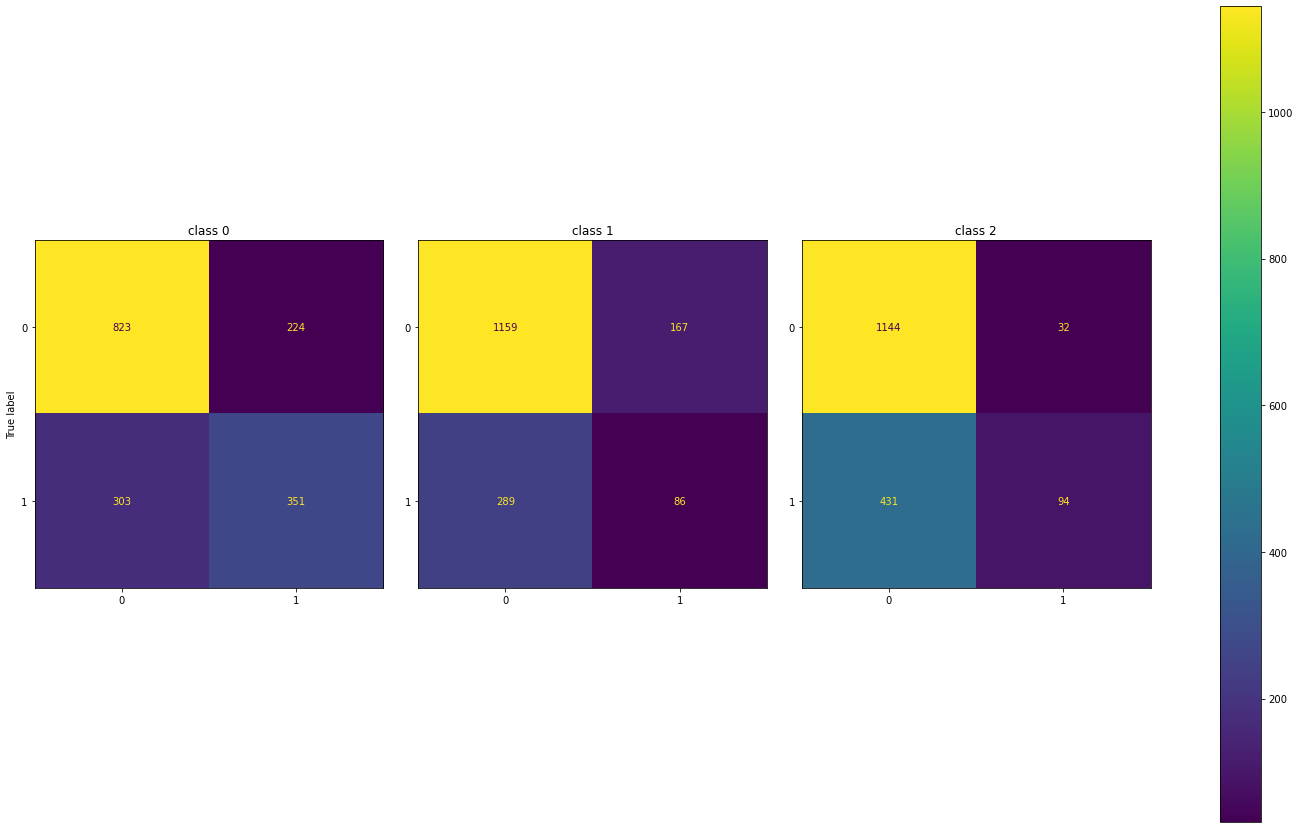

In [124]:
confusion_matrix(y_test, BR_pred)

# Word2vec

In [125]:
w2v_X_train_norm, w2v_X_test_norm =  min_max_scaler(w2v_X_train, np.array(w2v_X_test))
#X_train_norm, X_test_norm =  min_max_scaler(tf_X_train, tfidf_X_test.toarray())


In [126]:
w2v_clf, w2v_pred = build_binary_relevance(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)
calculate_metrics(w2v_pred)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'classifier': MultinomialNB(alpha=0), 'classifier__alpha': 0}
Best Score: 0.2730795729669688
Hamming Loss:  0.27552420145012735
Exact Match Ratio:  0.37742504409171074
Recall:  0.1833976833976834
Precision:  0.6753554502369669
Fl score:  0.28846153846153844
Accuracy:  0.37742504409171074
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.71      0.33      0.45       654
           1       0.41      0.08      0.13       375
           2       0.89      0.08      0.14       525

   micro avg       0.68      0.18      0.29      1554
   macro avg       0.67      0.16      0.24      1554
weighted avg       0.70      0.18      0.27      1554
 samples avg       0.14      0.14      0.14      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

# tfidf_w2v

In [127]:
w2v_tfidf_X_train_norm, w2v_tfidf_X_test_norm =  min_max_scaler(w2v_tfidf_X_train, np.array(w2v_tfidf_X_test))

In [128]:
w2v_tfidf_clf, w2v_tf_idf_pred = build_binary_relevance(w2v_tfidf_X_train_norm, w2v_tfidf_y_train , w2v_tfidf_X_test_norm)
calculate_metrics(w2v_tf_idf_pred)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'classifier': MultinomialNB(alpha=0), 'classifier__alpha': 0}
Best Score: 0.10948031708262267
Hamming Loss:  0.2933568489124045
Exact Match Ratio:  0.3368606701940035
Recall:  0.064993564993565
Precision:  0.696551724137931
Fl score:  0.11889346674514421
Accuracy:  0.3368606701940035
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.72      0.14      0.24       654
           1       0.46      0.02      0.03       375
           2       1.00      0.00      0.00       525

   micro avg       0.70      0.06      0.12      1554
   macro avg       0.73      0.05      0.09      1554
weighted avg       0.75      0.06      0.11      1554
 samples avg       0.05      0.05      0.05      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

# In TF_IDF,  using Svm classifier

In [129]:
def svm_classifier(X,y,X_te):

    parameters = [
    {
        'classifier': [SVC()],
        'classifier__C': [ 200, 175, 100, 75, 50]
    }
    ]

    clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
    clf.fit(X, y)
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Score: {clf.best_score_}")
    pred = clf.predict(X_te)
    return clf, pred                                           

In [130]:
tfidf_svm_clf, tfidf_svm_pred = svm_classifier(X_train_norm,tf_y_train,X_test_norm )

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'classifier': SVC(C=200), 'classifier__C': 200}
Best Score: 0.7920701427807575


In [131]:
calculate_metrics(tfidf_svm_pred)

Hamming Loss:  0.2039976484420929
Exact Match Ratio:  0.5526161081716637
Recall:  0.6106821106821106
Precision:  0.6851985559566787
Fl score:  0.6457978904389247
Accuracy:  0.5526161081716637
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       654
           1       0.51      0.43      0.47       375
           2       0.78      0.66      0.71       525

   micro avg       0.69      0.61      0.65      1554
   macro avg       0.67      0.59      0.62      1554
weighted avg       0.68      0.61      0.64      1554
 samples avg       0.45      0.44      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
#print(metrics.classification_report(svm_predictions, y_test))

# In BOW,  using Svm classifier

In [133]:
bow_svm_clf, bow_svm_pred = svm_classifier(bow_X_train, bow_y_train, bow_X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'classifier': SVC(C=50), 'classifier__C': 50}
Best Score: 0.6319918184727973


In [134]:
calculate_metrics(bow_svm_pred)

Hamming Loss:  0.19635508524397413
Exact Match Ratio:  0.5696649029982364
Recall:  0.5875160875160875
Precision:  0.716640502354788
Fl score:  0.6456859971711457
Accuracy:  0.5696649029982364
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       654
           1       0.54      0.36      0.43       375
           2       0.82      0.64      0.72       525

   micro avg       0.72      0.59      0.65      1554
   macro avg       0.69      0.56      0.62      1554
weighted avg       0.71      0.59      0.64      1554
 samples avg       0.45      0.43      0.42      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v

In [135]:
w2v_svm_clf, w2v_svm_pred = svm_classifier(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)
calculate_metrics(w2v_svm_pred)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'classifier': SVC(C=200), 'classifier__C': 200}
Best Score: 0.6592118747275468
Hamming Loss:  0.19028022731726435
Exact Match Ratio:  0.5749559082892416
Recall:  0.5752895752895753
Precision:  0.7419087136929461
Fl score:  0.6480608916274012
Accuracy:  0.5749559082892416
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       654
           1       0.53      0.47      0.50       375
           2       0.87      0.61      0.72       525

   micro avg       0.74      0.58      0.65      1554
   macro avg       0.73      0.56      0.63      1554
weighted avg       0.75      0.58      0.65      1554
 samples avg       0.45      0.42      0.42      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
#bow_svm_clf, bow_svm_pred = svm_classifier(bow_X_train, bow_y_train, bow_X_test)

# w2v_tfidf

In [137]:
w2v_tfidf_svm_clf, w2v_tf_idf_svm_pred = svm_classifier(w2v_tfidf_X_train_norm, w2v_tfidf_y_train , w2v_tfidf_X_test_norm)
calculate_metrics(w2v_tf_idf_svm_pred)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'classifier': SVC(C=200), 'classifier__C': 200}
Best Score: 0.6146549226499413
Hamming Loss:  0.21889084852047816
Exact Match Ratio:  0.5179306290417401
Recall:  0.5373230373230373
Precision:  0.6772100567721006
Fl score:  0.5992106207391461
Accuracy:  0.5179306290417401
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.71      0.57      0.64       654
           1       0.48      0.45      0.46       375
           2       0.82      0.56      0.66       525

   micro avg       0.68      0.54      0.60      1554
   macro avg       0.67      0.53      0.59      1554
weighted avg       0.69      0.54      0.60      1554
 samples avg       0.40      0.40      0.39      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Using TFIDF in log_reg classifier

In [138]:
def log_reg(X_tr, y_tr, X_te):
    
    parameters = [
    {   
        'classifier': [LogisticRegression()],
        "classifier__C":[0.01, 0.1, 10, 25, 50, 100],
        "classifier__penalty":['l2'],
        "classifier__solver":["newton-cg", "lbfgs", "liblinear", "sag"]

    }]

    clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1,verbose=2)
    clf.fit(X_tr, y_tr)
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Score: {clf.best_score_}")
    
    pred = clf.predict(X_te)
    
    return clf, pred

In [139]:
tfidf_lr_clf, tfidf_lr_pred = log_reg(X_train_norm,tf_y_train,X_test_norm)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier': LogisticRegression(C=10, solver='newton-cg'), 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
Best Score: 0.6624420659665129


In [140]:
calculate_metrics(tfidf_lr_pred)

Hamming Loss:  0.20007838526357044
Exact Match Ratio:  0.5455614344503233
Recall:  0.6048906048906049
Precision:  0.6978470675575352
Fl score:  0.6480523957256118
Accuracy:  0.5455614344503233
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       654
           1       0.48      0.50      0.49       375
           2       0.83      0.62      0.71       525

   micro avg       0.70      0.60      0.65      1554
   macro avg       0.69      0.59      0.63      1554
weighted avg       0.72      0.60      0.65      1554
 samples avg       0.45      0.44      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
#print(metrics.classification_report(log_predictions, y_test))

# BOW in LOGISTIC REGRESSION CLASSIFIER

In [142]:
bow_lr_clf, bow_lr_pred = log_reg(bow_X_train, bow_y_train, bow_X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier': LogisticRegression(C=100, solver='sag'), 'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
Best Score: 0.6843084054425974


C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [143]:
calculate_metrics(bow_lr_pred)

Hamming Loss:  0.17421124828532236
Exact Match Ratio:  0.60435038212816
Recall:  0.5566280566280566
Precision:  0.812206572769953
Fl score:  0.6605574646811759
Accuracy:  0.60435038212816
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       654
           1       0.71      0.32      0.44       375
           2       0.85      0.66      0.74       525

   micro avg       0.81      0.56      0.66      1554
   macro avg       0.79      0.53      0.63      1554
weighted avg       0.80      0.56      0.65      1554
 samples avg       0.44      0.41      0.42      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# W2V

In [144]:
w2v_lr_clf, w2v_lr_pred = log_reg(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)
calculate_metrics(w2v_lr_pred)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier': LogisticRegression(C=100, solver='liblinear'), 'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Score: 0.6123164772214266
Hamming Loss:  0.2087007642563198
Exact Match Ratio:  0.5367430922986478
Recall:  0.545045045045045
Precision:  0.7029045643153526
Fl score:  0.6139905762957593
Accuracy:  0.5367430922986478
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       654
           1       0.49      0.46      0.47       375
           2       0.85      0.53      0.65       525

   micro avg       0.70      0.55      0.61      1554
   macro avg       0.70      0.53      0.60      1554
weighted avg       0.72      0.55      0.62      1554
 samples avg       0.42      0.40      0.40      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v_tfidf

In [145]:
w2v_tfidf_lr_clf, w2v_tf_idf_lr_pred = log_reg(w2v_tfidf_X_train_norm, w2v_tfidf_y_train , w2v_tfidf_X_test_norm)
calculate_metrics(w2v_tf_idf_lr_pred)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier': LogisticRegression(C=100, solver='newton-cg'), 'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
Best Score: 0.5632889256738273
Hamming Loss:  0.23123652753282384
Exact Match Ratio:  0.48912404467960025
Recall:  0.4980694980694981
Precision:  0.6592844974446337
Fl score:  0.5674486803519062
Accuracy:  0.48912404467960025
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.70      0.57      0.63       654
           1       0.45      0.41      0.43       375
           2       0.82      0.48      0.61       525

   micro avg       0.66      0.50      0.57      1554
   macro avg       0.66      0.48      0.55      1554
weighted avg       0.68      0.50      0.57      1554
 samples avg       0.37      0.37      0.36      1554


C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# In TFIDF using Gaussian as classifier

In [146]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

In [147]:
def Gaussian_BinaryRelevance(X,y,X_te):

    parameters = [
    {
        'classifier': [GaussianNB(priors=None, var_smoothing=1e-09)]
    }
    ]

    clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
    clf.fit(X, y)
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Score: {clf.best_score_}")
    pred = clf.predict(X_te)
    return clf, pred                                           

In [148]:
Guassian_classifier, Guassian_predictions = Gaussian_BinaryRelevance(X_train_norm,tf_y_train, X_test_norm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB()}
Best Score: 0.5709308488831206


In [149]:
calculate_metrics(Guassian_predictions)

Hamming Loss:  0.46776406035665297
Exact Match Ratio:  0.16519694297472076
Recall:  0.8191763191763192
Precision:  0.37673868008286476
Fl score:  0.5161159537806608
Accuracy:  0.16519694297472076
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.48      0.82      0.60       654
           1       0.26      0.84      0.39       375
           2       0.41      0.81      0.54       525

   micro avg       0.38      0.82      0.52      1554
   macro avg       0.38      0.82      0.51      1554
weighted avg       0.40      0.82      0.53      1554
 samples avg       0.33      0.56      0.40      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# In BOW using Gaussian as classifier

In [150]:
bow_Guass_clf, bow_Guass_pred = Gaussian_BinaryRelevance(bow_X_train, bow_y_train, bow_X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB()}
Best Score: 0.5004781450451232


In [151]:
calculate_metrics(bow_Guass_pred)

Hamming Loss:  0.4756025867136978
Exact Match Ratio:  0.17166372721928277
Recall:  0.8545688545688546
Precision:  0.3763105695664494
Fl score:  0.5225260672831005
Accuracy:  0.17166372721928277
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.46      0.85      0.59       654
           1       0.25      0.90      0.40       375
           2       0.44      0.83      0.57       525

   micro avg       0.38      0.85      0.52      1554
   macro avg       0.38      0.86      0.52      1554
weighted avg       0.40      0.85      0.54      1554
 samples avg       0.35      0.59      0.41      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v


In [152]:
w2v_Guass_clf, w2v_Guass_pred = Gaussian_BinaryRelevance(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)
calculate_metrics(w2v_Guass_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB()}
Best Score: 0.5931173743020892
Hamming Loss:  0.3356848912404468
Exact Match Ratio:  0.291005291005291
Recall:  0.6692406692406693
Precision:  0.4644930772666369
Fl score:  0.5483785921434221
Accuracy:  0.291005291005291
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       654
           1       0.30      0.61      0.40       375
           2       0.51      0.75      0.61       525

   micro avg       0.46      0.67      0.55      1554
   macro avg       0.47      0.67      0.54      1554
weighted avg       0.50      0.67      0.56      1554
 samples avg       0.42      0.48      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v_tfidf

In [153]:
w2v_tfidf_Guass_clf, w2v_tf_idf_Guass_pred = Gaussian_BinaryRelevance(w2v_tfidf_X_train_norm, w2v_tfidf_y_train , w2v_tfidf_X_test_norm)
calculate_metrics(w2v_tf_idf_Guass_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB()}
Best Score: 0.5659702036486907
Hamming Loss:  0.33078581226729376
Exact Match Ratio:  0.2992357436801881
Recall:  0.637065637065637
Precision:  0.46830652790917693
Fl score:  0.5398037077426391
Accuracy:  0.2992357436801881
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       654
           1       0.33      0.57      0.42       375
           2       0.49      0.72      0.58       525

   micro avg       0.47      0.64      0.54      1554
   macro avg       0.46      0.63      0.53      1554
weighted avg       0.49      0.64      0.55      1554
 samples avg       0.41      0.46      0.41      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [154]:
#w2v_Guass_clf, w2v_Guass_pred = Gaussian_BinaryRelevance(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)

# Classifier_Chain

# In TFIDF using Gaussian as classifier

In [155]:
def GaussianClassifierChain(X,y,X_te):

    parameters = [
    {
        'classifier': [GaussianNB(priors=None, var_smoothing = 1e-01)]
    }
    ]

    clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
    clf.fit(X, y)
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Score: {clf.best_score_}")
    pred = clf.predict(X_te)
    return clf, pred                                           

In [156]:
Guass_Classifier_Chain, Guass_Classifier_prediction = GaussianClassifierChain(X_train_norm,tf_y_train,X_test_norm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB(var_smoothing=0.1)}
Best Score: 0.6092983383413852


In [157]:
calculate_metrics(Guass_Classifier_prediction)

Hamming Loss:  0.3821281599059377
Exact Match Ratio:  0.23515579071134626
Recall:  0.787001287001287
Precision:  0.4303307529908515
Fl score:  0.5564149226569609
Accuracy:  0.23515579071134626
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.48      0.85      0.61       654
           1       0.33      0.67      0.44       375
           2       0.46      0.79      0.58       525

   micro avg       0.43      0.79      0.56      1554
   macro avg       0.42      0.77      0.54      1554
weighted avg       0.43      0.79      0.56      1554
 samples avg       0.38      0.55      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BOW_Guassian

In [158]:
bow_Guass_chain_clf, bow_Guass_chain_pred = GaussianClassifierChain(bow_X_train, bow_y_train, bow_X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB(var_smoothing=0.1)}
Best Score: 0.5820144621163902


In [159]:
calculate_metrics(bow_Guass_chain_pred)

Hamming Loss:  0.3592004703115814
Exact Match Ratio:  0.22457378012933568
Recall:  0.8088803088803089
Precision:  0.45005370569280345
Fl score:  0.5783298826777088
Accuracy:  0.22457378012933568
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.43      0.96      0.59       654
           1       0.33      0.73      0.45       375
           2       0.72      0.68      0.70       525

   micro avg       0.45      0.81      0.58      1554
   macro avg       0.49      0.79      0.58      1554
weighted avg       0.50      0.81      0.59      1554
 samples avg       0.42      0.57      0.46      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v

In [160]:
w2v_Guass_chain_clf, w2v_Guass_chain_pred = GaussianClassifierChain(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)
calculate_metrics(w2v_Guass_chain_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB(var_smoothing=0.1)}
Best Score: 0.5928439581614869
Hamming Loss:  0.3370566333529296
Exact Match Ratio:  0.2880658436213992
Recall:  0.6737451737451737
Precision:  0.4632743362831858
Fl score:  0.5490298898793917
Accuracy:  0.2880658436213992
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       654
           1       0.30      0.62      0.41       375
           2       0.50      0.76      0.60       525

   micro avg       0.46      0.67      0.55      1554
   macro avg       0.47      0.67      0.54      1554
weighted avg       0.49      0.67      0.56      1554
 samples avg       0.42      0.49      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v_tfidf

In [161]:
w2v_tfidf__Gchain_clf, w2v_tfidf_Gchain_pred = GaussianClassifierChain(w2v_tfidf_X_train_norm, w2v_tfidf_y_train , w2v_tfidf_X_test_norm)
calculate_metrics(w2v_tfidf_Gchain_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB(var_smoothing=0.1)}
Best Score: 0.5585825049575759
Hamming Loss:  0.3294140701548109
Exact Match Ratio:  0.2998236331569665
Recall:  0.6428571428571429
Precision:  0.47011764705882353
Fl score:  0.5430823593367763
Accuracy:  0.2998236331569665
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       654
           1       0.33      0.56      0.42       375
           2       0.48      0.75      0.59       525

   micro avg       0.47      0.64      0.54      1554
   macro avg       0.47      0.64      0.53      1554
weighted avg       0.49      0.64      0.55      1554
 samples avg       0.41      0.47      0.42      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LabelPowerSet

# In TFIDF using Gaussian as classifier 

In [162]:
def label_Guassian(X,y,X_te):

    parameters = [
    {
        'classifier': [GaussianNB(priors=None, var_smoothing = 1e-01)]
    }
    ]

    clf = GridSearchCV(BinaryRelevance(), parameters, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
    clf.fit(X, y)
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Score: {clf.best_score_}")
    pred = clf.predict(X_te)
    return clf, pred        

In [163]:
label_clf, label_predictions = label_Guassian(X_train_norm,tf_y_train,X_test_norm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB(var_smoothing=0.1)}
Best Score: 0.6092983383413852


In [164]:
calculate_metrics(label_predictions)

Hamming Loss:  0.3821281599059377
Exact Match Ratio:  0.23515579071134626
Recall:  0.787001287001287
Precision:  0.4303307529908515
Fl score:  0.5564149226569609
Accuracy:  0.23515579071134626
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.48      0.85      0.61       654
           1       0.33      0.67      0.44       375
           2       0.46      0.79      0.58       525

   micro avg       0.43      0.79      0.56      1554
   macro avg       0.42      0.77      0.54      1554
weighted avg       0.43      0.79      0.56      1554
 samples avg       0.38      0.55      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BOW_Label_Guassian

In [165]:
bow_Guass_label_clf, bow_Guass_label_pred = label_Guassian(bow_X_train, bow_y_train, bow_X_test)
calculate_metrics(bow_Guass_label_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB(var_smoothing=0.1)}
Best Score: 0.5820144621163902
Hamming Loss:  0.3592004703115814
Exact Match Ratio:  0.22457378012933568
Recall:  0.8088803088803089
Precision:  0.45005370569280345
Fl score:  0.5783298826777088
Accuracy:  0.22457378012933568
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.43      0.96      0.59       654
           1       0.33      0.73      0.45       375
           2       0.72      0.68      0.70       525

   micro avg       0.45      0.81      0.58      1554
   macro avg       0.49      0.79      0.58      1554
weighted avg       0.50      0.81      0.59      1554
 samples avg       0.42      0.57      0.46      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
w2v_Guass_label_clf, w2v_Guass_label_pred = label_Guassian(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)
calculate_metrics(w2v_Guass_label_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB(var_smoothing=0.1)}
Best Score: 0.5928439581614869
Hamming Loss:  0.3370566333529296
Exact Match Ratio:  0.2880658436213992
Recall:  0.6737451737451737
Precision:  0.4632743362831858
Fl score:  0.5490298898793917
Accuracy:  0.2880658436213992
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       654
           1       0.30      0.62      0.41       375
           2       0.50      0.76      0.60       525

   micro avg       0.46      0.67      0.55      1554
   macro avg       0.47      0.67      0.54      1554
weighted avg       0.49      0.67      0.56      1554
 samples avg       0.42      0.49      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v_tfidf

In [167]:
w2v_tfidf__label_clf, w2v_tfidf_label_pred = label_Guassian(w2v_tfidf_X_train_norm, w2v_tfidf_y_train , w2v_tfidf_X_test_norm)
calculate_metrics(w2v_tfidf_label_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier': GaussianNB(var_smoothing=0.1)}
Best Score: 0.5585825049575759
Hamming Loss:  0.3294140701548109
Exact Match Ratio:  0.2998236331569665
Recall:  0.6428571428571429
Precision:  0.47011764705882353
Fl score:  0.5430823593367763
Accuracy:  0.2998236331569665
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       654
           1       0.33      0.56      0.42       375
           2       0.48      0.75      0.59       525

   micro avg       0.47      0.64      0.54      1554
   macro avg       0.47      0.64      0.53      1554
weighted avg       0.49      0.64      0.55      1554
 samples avg       0.41      0.47      0.42      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Ensemble method

In [114]:
from sklearn.ensemble import RandomForestClassifier

# tfidf 

In [169]:
def random_forest(X_tr, y_tr, X_te ):
    parameters = [ 
        {'bootstrap': [True, False],
 'max_depth': [10, 25, 50, 75, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 50, 100]    
}
    ]
    model = RandomForestClassifier()
    clf = RandomizedSearchCV(estimator = model , param_distributions = parameters, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    clf.fit(X_tr, y_tr)
    predictions = clf.predict(X_te)
    print(f"Best parameters: {clf.best_params_}")
    print(f"Best Score: {clf.best_score_}")
    
    return clf, predictions       

In [170]:
tfidf_randf_clf, tf_idf_randf_pred = random_forest(X_train_norm, tf_y_train,X_test_norm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
Best Score: 0.6623969814318339


In [171]:
calculate_metrics(tf_idf_randf_pred)

Hamming Loss:  0.1691162061532432
Exact Match Ratio:  0.6137566137566137
Recall:  0.584942084942085
Precision:  0.8065661047027507
Fl score:  0.6781051846325997
Accuracy:  0.6137566137566137
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.84      0.63      0.72       654
           1       0.61      0.42      0.50       375
           2       0.90      0.64      0.75       525

   micro avg       0.81      0.58      0.68      1554
   macro avg       0.78      0.56      0.66      1554
weighted avg       0.80      0.58      0.68      1554
 samples avg       0.46      0.42      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save Best Model

# write the model

In [172]:
model = tfidf_randf_clf

In [173]:
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model\Random_forest_tfidf.pkl", "wb") as pickle_file:
    pickle.dump(model, pickle_file)   

# load the saved model

In [174]:
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model\Random_forest_tfidf.pkl", "rb") as pickel_file:
    loaded_model = pickle.load(pickel_file)   

# BOW

In [175]:
bow_randf_clf, bow_randf_pred = random_forest(bow_X_train, bow_y_train, bow_X_test)
calculate_metrics(bow_randf_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best Score: 0.6345413513872296
Hamming Loss:  0.1638252008622379
Exact Match Ratio:  0.6290417401528513
Recall:  0.5643500643500643
Precision:  0.8465250965250966
Fl score:  0.6772200772200773
Accuracy:  0.6290417401528513
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       654
           1       0.81      0.30      0.43       375
           2       0.88      0.67      0.76       525

   micro avg       0.85      0.56      0.68      1554
   macro avg       0.84      0.53      0.64      1554
weighted avg       0.84      0.56      0.66      1554
 samples avg       0.47      0.42      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save the model via writing and loading

In [176]:
#write
random_bow = bow_randf_clf  #, bow_randf_pred 
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model\Random_forest_bow.pkl", "wb") as pickle_file:
    pickle.dump(random_bow, pickle_file)   

In [177]:
#open
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model\Random_forest_bow.pkl", "rb") as pickel_file:
    loaded_model = pickle.load(pickel_file)   


In [178]:
w2v_randf_clf, w2v_randf_pred = random_forest(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)
calculate_metrics(w2v_randf_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best Score: 0.6344950848972297
Hamming Loss:  0.21262002743484226
Exact Match Ratio:  0.5238095238095238
Recall:  0.5379665379665379
Precision:  0.6949293433083957
Fl score:  0.60645629307218
Accuracy:  0.5238095238095238
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       654
           1       0.52      0.34      0.41       375
           2       0.81      0.58      0.67       525

   micro avg       0.69      0.54      0.61      1554
   macro avg       0.68      0.51      0.58      1554
weighted avg       0.69      0.54      0.60      1554
 samples avg       0.42      0.39      0.40      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v_tfidf

In [179]:
w2v_tfidf__randf_clf, w2v_tfidf_randf_pred = random_forest(w2v_tfidf_X_train_norm, w2v_tfidf_y_train , w2v_tfidf_X_test_norm)
calculate_metrics(w2v_tfidf_randf_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best Score: 0.6174163439578989
Hamming Loss:  0.2237899274936312
Exact Match Ratio:  0.5049970605526161
Recall:  0.5148005148005148
Precision:  0.6734006734006734
Fl score:  0.5835156819839534
Accuracy:  0.5049970605526161
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.68      0.61      0.64       654
           1       0.50      0.33      0.40       375
           2       0.78      0.53      0.63       525

   micro avg       0.67      0.51      0.58      1554
   macro avg       0.65      0.49      0.56      1554
weighted avg       0.67      0.51      0.58      1554
 samples avg       0.40      0.38      0.38      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier

In [116]:
def xgb_estimator(X_tr, y_tr, X_te):
    
    xgb_estimator = xgb.XGBClassifier(objective='binary:logistic')

    # create MultiOutputClassifier instance with XGBoost model inside
    multilabel_model = MultiOutputClassifier(xgb_estimator)

    # fit the model
    multilabel_model.fit(X_tr, y_tr)
    predictions = multilabel_model.predict(X_te)
    return multilabel_model, predictions

In [117]:
tfidf_xgb_clf, tfidf_xgb_pred = xgb_estimator(X_train_norm, tf_y_train,X_test_norm)
calculate_metrics(tfidf_xgb_pred)

Hamming Loss:  0.1773466588281403
Exact Match Ratio:  0.5937683715461494
Recall:  0.5926640926640927
Precision:  0.7720033528918693
Fl score:  0.6705496905715327
Accuracy:  0.5937683715461494
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       654
           1       0.56      0.46      0.50       375
           2       0.89      0.63      0.74       525

   micro avg       0.77      0.59      0.67      1554
   macro avg       0.75      0.58      0.65      1554
weighted avg       0.78      0.59      0.67      1554
 samples avg       0.46      0.43      0.43      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save the model

In [118]:
#write
xgboost_tfidf = tfidf_xgb_clf  
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/xgboost_tfidf.pkl", "wb") as pickle_file:
    pickle.dump(xgboost_tfidf, pickle_file)   

In [119]:
#open
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/xgboost_tfidf.pkl", "rb") as pickel_file:
    loaded_model = pickle.load(pickel_file)   

# BOW

In [120]:
bow_xgb_clf, bow_xgb_pred = xgb_estimator(bow_X_train, bow_y_train, bow_X_test)
calculate_metrics(bow_xgb_pred)

Hamming Loss:  0.17264354301391338
Exact Match Ratio:  0.6072898295120517
Recall:  0.5347490347490348
Precision:  0.840242669362993
Fl score:  0.6535587888320881
Accuracy:  0.6072898295120517
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.84      0.58      0.69       654
           1       0.76      0.29      0.42       375
           2       0.87      0.65      0.75       525

   micro avg       0.84      0.53      0.65      1554
   macro avg       0.82      0.51      0.62      1554
weighted avg       0.83      0.53      0.64      1554
 samples avg       0.44      0.40      0.41      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save the model

In [121]:
#write
xgboost_bow = bow_xgb_clf  
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/xgboost_bow.pkl", "wb") as pickle_file:
    pickle.dump(xgboost_bow, pickle_file)

In [122]:
#open
with open("D:\Main thesis\safecity-master\SafeCity_Main Project\Best_model/xgboost_bow.pkl", "rb") as pickel_file:
    loaded_model = pickle.load(pickel_file)   

In [123]:
loaded_model

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None,
                                              reg_alpha=None, reg_lambda=None, ...))

# w2v

In [188]:
w2v_xgb_clf, w2v_xgb_pred = xgb_estimator(w2v_X_train_norm, w2v_y_train, w2v_X_test_norm)
calculate_metrics(w2v_xgb_pred)

Hamming Loss:  0.21712718009014306
Exact Match Ratio:  0.520870076425632
Recall:  0.5707850707850708
Precision:  0.6679216867469879
Fl score:  0.6155447605829285
Accuracy:  0.520870076425632
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       654
           1       0.47      0.41      0.44       375
           2       0.78      0.62      0.69       525

   micro avg       0.67      0.57      0.62      1554
   macro avg       0.65      0.55      0.60      1554
weighted avg       0.67      0.57      0.62      1554
 samples avg       0.44      0.42      0.41      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# w2v_tfidf

In [189]:
w2v_tfidf__xgb_clf, w2v_tfidf_xgb_pred = random_forest(w2v_tfidf_X_train_norm, w2v_tfidf_y_train , w2v_tfidf_X_test_norm)
calculate_metrics(w2v_tfidf_xgb_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best Score: 0.6147353788104458
Hamming Loss:  0.23064863805604546
Exact Match Ratio:  0.49029982363315694
Recall:  0.5019305019305019
Precision:  0.6593406593406593
Fl score:  0.5699671172816952
Accuracy:  0.49029982363315694
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       654
           1       0.49      0.31      0.38       375
           2       0.76      0.54      0.63       525

   micro avg       0.66      0.50      0.57      1554
   macro avg       0.64      0.48      0.54      1554
weighted avg       0.66      0.50      0.57      1554
 samples avg       0.39      0.37      0.37      1554



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Implementing Classifier Chain from scratch using logistic regression

#### Using TF_IDF vectorizer

In [190]:
def initialize_weights_bias(dim):
    ''' In this function, we will initialize our weights and bias terms'''
    

    # Initialize the weights to zeros array of (dim) dimensions. Here dim will be the number of features of your tfidf vectorizer output.
    # You can initialize the weight terms with zeros.
    # Initialize bias term to zero
    # Write your code below.
    w = np.zeros(dim)
    b = 0
    return w,b

In [191]:
#dim = X_train_norm.shape[1] # tf_y_train, X_test_norm, X_train_norm
#weight_init_1 = initialize_weights_bias(dim)

In [192]:
def custom_sigmoid(z):
    ''' In this function, we will return sigmoid of z'''
    
    # Compute sigmoid(z) and return its value.
    # Write your code below.
    
    sigmoid = 1/(1 + np.exp(-z))
    return sigmoid

In [193]:
import itertools
import math
from math import log10

In [194]:
def absloute_value(values):
    l1_loss = 0
    for v in values:
        l1_loss += abs(v)
    return l1_loss

In [195]:
def custom_loss(y_true, y_pred, alpha, weights):
    '''In this function, we will compute total loss which is [(logloss) + (alpha * L1regularization loss)] '''
    
    # Write your code below.
    
    log_loss = 0
    n = len(y_true)
    
    for y_true, y_pred in zip(y_true,y_pred):
         log_loss += y_true*np.log10(y_pred)+(1-y_true)*log10(1-y_pred)
    
    log_loss = -log_loss/n
    
    l1_loss = absloute_value(weights)
 
    total_loss = log_loss + (alpha*l1_loss) 
    
    return total_loss

In [196]:
def gradient_dw(x, y, w, b, alpha, N):
    '''In this function, we will compute the gardient w.r.t. w '''
    # Write your code below.
    dw = ((custom_sigmoid(np.dot(x, w) + b) - y) *  x) + ((alpha/N) * (w + 1e-5 / abs(w + 1e-5)))
    return dw

In [197]:
def gradient_db(x, y, w, b):
    '''In this function, we will compute the gardient w.r.t. b '''
    # Write your code below.
    db = custom_sigmoid(np.dot(w,x) + b) - y
    return db

In [198]:
def custom_train(X_train, y_train, alpha, eta0, tolerance):
    N = X_train.shape[1]
    w, b = initialize_weights_bias(N)
    # *((w + (np.exp(-5))) / (w + abs(np.exp(-5))))   #w+(1e−5)|
    epoch = 1000
    train_losses = []
    
    with tqdm(total=epoch, position=0, leave=True) as pbar:
        for e in tqdm(range(epoch), position=0, leave=True):
            for x, y in zip(X_train, y_train):
                dw = gradient_dw(x, y, w, b, alpha, N)
                db = gradient_db(x, y, w, b)
                w = w - eta0 * dw
                b = b - eta0 * db
            y_pred = [custom_sigmoid(np.dot(w, x)) for x in X_train]
            train_loss = custom_loss(y_train, y_pred, alpha, w)
            train_losses.append(train_loss)

            if len(train_losses)>=2 and train_losses[-2] - train_losses[-1]  <  tolerance:
                  break
            pbar.update()
        
    print(f"Epoch: {e} Train Loss: {train_loss}")

    return w, b, train_losses

In [199]:
X_train_norm, X_test_norm =  min_max_scaler(tf_X_train, tfidf_X_test.toarray())
X_train_norm.shape, X_test_norm.shape

((10071, 716), (1701, 716))

In [200]:
def predict(w,b, X, threshold):
    
    '''function to predict label given weights, bias and standardized data'''
    
    #m = X.shape[1]
    #Y_prediction = np.zeros((1, m))
    #w = w.reshape(X.shape[0], 1)
    
    predictions = []
    for x in X:
        z = np.dot(w, x) + b
        prediction = custom_sigmoid(z)
        pred = 1 if prediction < threshold else 1
        predictions.append([pred])
    
    return np.array(predictions) #it should be a numpy array

Concatenate input from X_test and classifier_1 prediction as input to predict classifier_2

In [201]:
def plot_loss(loss, classifier_name):
    epoch = len(loss)
    plt.plot(range(epoch), loss, label='train curve')
    plt.title(f'epoch vs loss = {classifier_name}')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [202]:
def calculate_metrics(predictions, y_test):
    print("Hamming Loss: ", hamming_loss(y_test, predictions))
#     print("Exact Match Ratio: ", exact_match_ratio(y_test, predictions))
    print("Recall: ", recall_score(y_true=y_test, y_pred = predictions, average='micro'))
    print("Precision: ", precision_score(y_true=y_test, y_pred = predictions, average='micro'))
    print("Fl score: ", f1_score(y_true=y_test, y_pred=predictions, average='micro'))
    print("Accuracy: ", accuracy_score(y_true=y_test, y_pred=predictions))
    print(" ")
    print("*****************************************************************************")
    print("")
    print("metrics.classification_report: ")
    print(classification_report(y_test, predictions))

In [203]:
def chain_classifier(X, y):
    ran = y.shape[1]
    upd_x = X
    upd_y = y[:, 0]
    print(f"The shape of the updated X: {upd_x.shape}")
    print(f"The number of the classifier {ran}")
    pred_y1 = []
    classifier_values = {}
    for i in range(0, ran):
        w, b, train_losses = custom_train(upd_x, upd_y, 0.000001,0.0001,0.000001)
        pred_y = predict(w, b, upd_x, 0.4)
        calculate_metrics(pred_y,upd_y)   
        pred_y1.append(pred_y)
        plot_loss(train_losses, i)
        classifier_values[i] = {"weights": w, "bias": b}
        upd_x = np.append(upd_x, pred_y, axis=1)
        upd_y = y[:, i]
        print(f"The shape of the updated X: {upd_x.shape}")
        
    return classifier_values, pred_y1

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

The shape of the updated X: (10071, 716)
The number of the classifier 3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:05<00:00,  3.27it/s]
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

Epoch: 999 Train Loss: 0.21968807989042577
Hamming Loss:  0.6144374937940622
Recall:  0.38556250620593785
Precision:  0.38556250620593785
Fl score:  0.3855625062059378
Accuracy:  0.38556250620593785
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6188
         1.0       0.39      1.00      0.56      3883

    accuracy                           0.39     10071
   macro avg       0.19      0.50      0.28     10071
weighted avg       0.15      0.39      0.21     10071



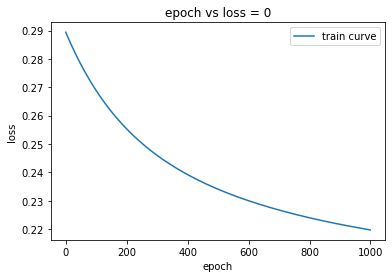

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

The shape of the updated X: (10071, 717)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:06<00:00,  3.27it/s]
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

Epoch: 999 Train Loss: 0.21966019669124118
Hamming Loss:  0.6144374937940622
Recall:  0.38556250620593785
Precision:  0.38556250620593785
Fl score:  0.3855625062059378
Accuracy:  0.38556250620593785
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6188
         1.0       0.39      1.00      0.56      3883

    accuracy                           0.39     10071
   macro avg       0.19      0.50      0.28     10071
weighted avg       0.15      0.39      0.21     10071



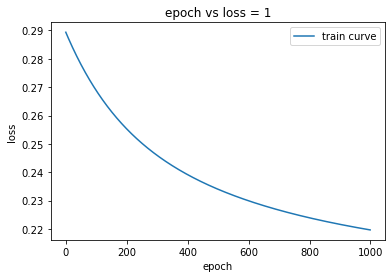

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

The shape of the updated X: (10071, 718)


  0%|                                                                                 | 1/1000 [00:00<10:05,  1.65it/s]

Epoch: 1 Train Loss: 0.34120891242236623
Hamming Loss:  0.5952735577400456
Recall:  0.4047264422599543
Precision:  0.4047264422599543
Fl score:  0.4047264422599543
Accuracy:  0.4047264422599543
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5995
         1.0       0.40      1.00      0.58      4076

    accuracy                           0.40     10071
   macro avg       0.20      0.50      0.29     10071
weighted avg       0.16      0.40      0.23     10071




C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


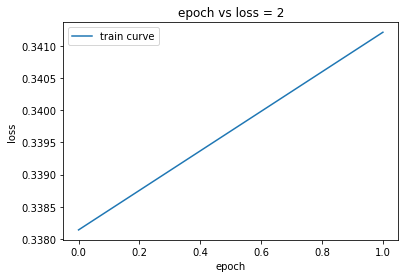

The shape of the updated X: (10071, 719)


In [204]:
classifier_values, pred = chain_classifier(X_train_norm, tf_y_train)

In [205]:
#print(pred[0] == pred[1])

# Deep Learning custom model

In [206]:
from numpy import asarray
from sklearn.datasets import make_multilabel_classification
from keras.models import Sequential
from keras.layers import Dense

In [207]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(30, input_dim=20, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(40, input_dim=30, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, input_dim=40, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [208]:
def model(n_inputs, n_outputs, x,y, epochs):
    model = get_model(n_inputs, n_outputs)
    model.fit(x,y,epochs)
    return model
    
model= model(X_train_norm.shape[1], tf_y_train.shape[1], X_train_norm, tf_y_train, epochs=100)

101/101 [==============================] - 0s 950us/step - loss: 0.6477


In [209]:
y_pred = model.predict(X_train_norm)

In [210]:
tf_y_train.shape, y_pred.shape

((10071, 3), (10071, 3))

In [211]:
for i in range(tf_y_train.shape[1]):
    y_pred_bin = [1 if y_pred[:, i][x] > 0.5 else 0 for x in range(tf_y_train.shape[0])]
    calculate_metrics(tf_y_train[:, i].astype(int), np.array(y_pred_bin))

Hamming Loss:  0.38556250620593785
Recall:  0.6144374937940622
Precision:  0.6144374937940622
Fl score:  0.6144374937940622
Accuracy:  0.6144374937940622
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     10071
           1       0.00      0.00      0.00         0

    accuracy                           0.61     10071
   macro avg       0.50      0.31      0.38     10071
weighted avg       1.00      0.61      0.76     10071

Hamming Loss:  0.4047264422599543
Recall:  0.5952735577400456
Precision:  0.5952735577400456
Fl score:  0.5952735577400456
Accuracy:  0.5952735577400456
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.60      0.75     10071
           1       0.00      0.

C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classif

# Save the model in pickle format

In [212]:
model.save("Best_model\dlmodel.pkl")

INFO:tensorflow:Assets written to: Best_model\dlmodel.pkl\assets


In [213]:
#with open("D:\Main thesis\safecity-master\SafeCity_Main Project\safecity_streamlit_webapp\data\deep_learning_model/dl_model.pkl", "rb") as pickle_file:
 #   dl_model = pickle.load(pickle_file) 

### Predicting test data

In [214]:
y_pred = model.predict(X_test_norm)
y_pred

array([[0.40603667, 0.41235054, 0.25968707],
       [0.40198797, 0.4134559 , 0.26940763],
       [0.40813136, 0.4172433 , 0.27946156],
       ...,
       [0.4099709 , 0.4181429 , 0.27945903],
       [0.40641904, 0.41533226, 0.2736058 ],
       [0.38950306, 0.41872954, 0.255058  ]], dtype=float32)

In [215]:
y_pred_bins = []
for i in range(y_test.shape[1]):
    y_pred_bin = [1 if y_pred[:, i][x] > 0.5 else 0 for x in range(y_test.shape[0])]
    y_pred_bins.append(y_pred_bin)

In [216]:
calculate_metrics(y_test.astype(int), np.transpose(y_pred_bins))

Hamming Loss:  0.3045267489711934
Recall:  0.0
Precision:  0.0
Fl score:  0.0
Accuracy:  0.31746031746031744
 
*****************************************************************************

metrics.classification_report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0
 samples avg       0.00      0.00      0.00         0



C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dhivakar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMet